In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow import keras

In [2]:
# Directory paths
base_dir = '/Users/yashwanth/Downloads/Data/Lung Disease Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
# Image dimensions and batch size
img_height = 256
img_width = 256
batch_size = 20


In [4]:
# Rescaling images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 6060 images belonging to 5 classes.
Found 1800 images belonging to 5 classes.


In [5]:
# Model structure
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax')) # Change the final layer neurons to match the number of classes


2024-04-01 18:32:02.713558: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-04-01 18:32:02.713595: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-04-01 18:32:02.713652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-04-01 18:32:02.713798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-01 18:32:02.713831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

# Model summary to see the structure and parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 127, 127, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                        

In [7]:
# Fit the model (Assuming 'train_generator' and 'validation_generator' are already defined)
history = model.fit(
    train_generator,
    epochs=50,  # Or however many epochs were determined to be optimal during tuning
    validation_data=validation_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)


Epoch 1/50


2024-04-01 18:32:08.164409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


303/303 [==============================] - ETA: 0s - loss: 65350.9961 - accuracy: 0.4523

2024-04-01 18:32:52.157516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


303/303 [==============================] - 57s 184ms/step - loss: 65350.9961 - accuracy: 0.4523 - val_loss: 800523.3125 - val_accuracy: 0.2417
Epoch 2/50
303/303 [==============================] - 56s 185ms/step - loss: 23904192.0000 - accuracy: 0.3606 - val_loss: 49920488.0000 - val_accuracy: 0.3111
Epoch 3/50
303/303 [==============================] - 56s 184ms/step - loss: 267557792.0000 - accuracy: 0.3665 - val_loss: 1089406848.0000 - val_accuracy: 0.1883
Epoch 4/50
303/303 [==============================] - 56s 183ms/step - loss: 1056194496.0000 - accuracy: 0.3653 - val_loss: 7694928896.0000 - val_accuracy: 0.1372
Epoch 5/50
303/303 [==============================] - 56s 184ms/step - loss: 2373660672.0000 - accuracy: 0.3637 - val_loss: 38609285120.0000 - val_accuracy: 0.1172
Epoch 6/50
303/303 [==============================] - 56s 183ms/step - loss: 6113160704.0000 - accuracy: 0.3507 - val_loss: 25383454720.0000 - val_accuracy: 0.1894


In [8]:
# Save the model
model.save('best_model.h5')

/Users/chaitanyapavan/anaconda3/envs/tf_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

In [10]:
# Load the saved model
model = load_model('best_model.h5')


In [8]:
# Preparing the test data generator (do not shuffle the test data)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False) # Important for correct label order

Found 1951 images belonging to 5 classes.


In [9]:
# Predict the test set
test_generator.reset()  # Resetting the generator to ensure proper label order
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

 4/97 [>.............................] - ETA: 4s

2024-04-01 18:37:43.570430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - 13s 131ms/step


NameError: name 'np' is not defined

In [ ]:
import math

# Correct calculation of steps to include all samples
steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Use the corrected steps in model.predict
predictions = model.predict(test_generator, steps=steps)
predicted_classes = np.argmax(predictions, axis=1)

# Adjusting the true_classes array length if necessary
# This ensures true_classes and predicted_classes have the same length
if len(predicted_classes) != len(true_classes):
    true_classes = true_classes[:len(predicted_classes)]

# Now proceed with your evaluation
_, accuracy = model.evaluate(test_generator, steps=steps)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Confusion Matrix:')
print(conf_matrix)

class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print('Classification Report:')
print(class_report)


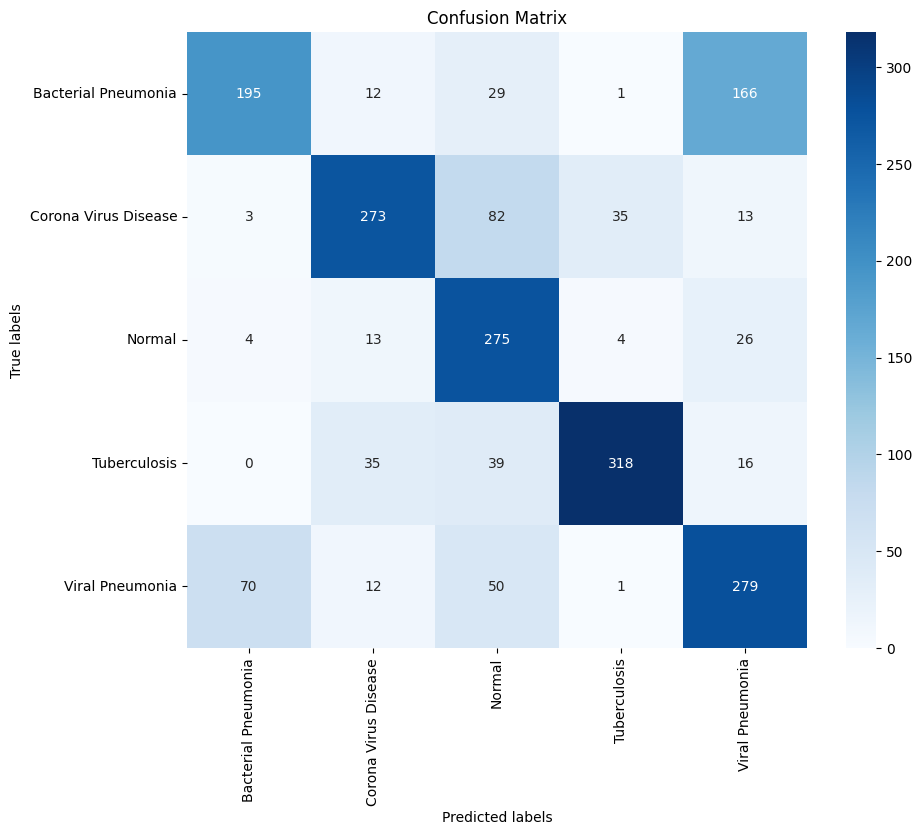

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming conf_matrix and class_labels are defined from the previous steps

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [49]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

In [50]:
# Function to generate Grad-CAM heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [51]:
from tensorflow.keras.models import load_model


# Function to find the last convolutional layer in the model
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        # Check if the layer is a convolutional layer
        if 'conv' in layer.__class__.__name__.lower():
            return layer.name
    return None

last_conv_layer_name = find_last_conv_layer(model)

print("Last convolutional layer name:", last_conv_layer_name)

Last convolutional layer name: conv2d_2


In [52]:
# Load and preprocess the image
img_path = '/Users/chaitanyapavan/Downloads/Data/Lung Disease Dataset/test/Bacterial Pneumonia/BACTERIA-8054264-0005.jpeg'

img = image.load_img(img_path, target_size=(256, 256,3))  # Adjust to the expected input size of your model
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
img_array /= 255.0  # Normalize to [0,1]


In [53]:
# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

/var/folders/pl/tqnpqw0d0lg1qyvvvs2sk2kr0000gn/T/ipykernel_2792/3732121559.py:6: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)  # Convert heatmap to RGB
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


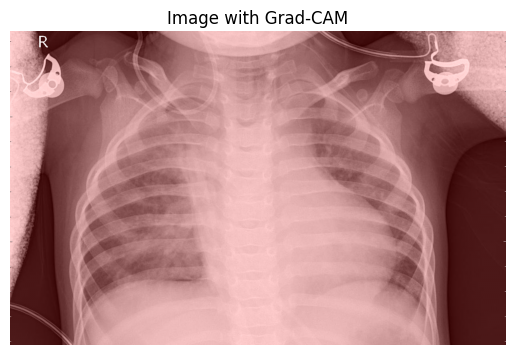

In [54]:
# Load the original image (without resizing) to match its actual size
orig_img = cv2.imread(img_path)
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

# Resize the heatmap to match the original image size
heatmap = np.uint8(255 * heatmap)  # Convert heatmap to RGB
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply the heatmap color mapping
heatmap_resized = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))

# Superimpose the heatmap on the original image
superimposed_img = heatmap_resized * 0.4 + orig_img

# Display the superimposed image
plt.imshow(superimposed_img / 255)
plt.title("Image with Grad-CAM")
plt.axis('off')
plt.show()